In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
from sklearn import metrics
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0005
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 39798
SL_VALIDATION_SIZE = 9950
SL_TEST_SIZE = 16728
BKG_TEST_SIZE = 322188
EPOCHS = 30
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1
TEST_STEPS = (SL_TEST_SIZE + BKG_TEST_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_1_model.json"
WEIGHTS_PATH = "./binary_classifier/net_1_weights.h5"

rand.seed(42)

In [3]:
# def test_generator(batch_size):
#     test_set = []
#     lst = os.listdir(TEST_PATH + 'sea_lions')
#     for elem in lst:
#         test_set.append(list((elem, 'sea_lion')))
#     lst = os.listdir(TEST_PATH + 'background')
#     for elem in lst:
#         test_set.append(list((elem, 'background')))
#     rand.shuffle(test_set)
#     curr_batch_size = 0
#     patches = []
#     classes = []
#     for elem in test_set:
#         if elem[1] == 'background':
#             patches.append(cv2.imread(TEST_PATH + 'background/' + elem[0]))
#             classes.append([0, 1])
#         else:
#             patches.append(cv2.imread(TEST_PATH + 'sea_lions/' + elem[0]))
#             classes.append([1, 0])
#         curr_batch_size += 1
#         if curr_batch_size == batch_size:
#             X_test = np.array(patches)
#             X_test = X_test.astype('float32')
#             X_test /= 255
#             Y_test = np.array(classes)
#             patches = []
#             classes = []
#             yield X_test, Y_test
#     if len(patches) > 0:
#         X_test = np.array(patches)
#         X_test = X_test.astype('float32')
#         X_test /= 255
#         Y_test = np.array(classes)
#         yield X_test, Y_test


In [4]:
# def prediction_generator(batch_size, steps):
#     test_gen = test_generator(batch_size)
#     Y_roc = []
#     while steps > 0:
#         x, y = next(test_gen)
#         Y_roc.append(y.tolist())
#         steps -= 1
#         yield x
#     yield np.array(Y_roc)

In [5]:
# Load parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)

# Load weights
parallel_model.load_weights(WEIGHTS_PATH)

parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [6]:
# # Test (multi gpu)
# 
# # Evaluate model on test data
# loss_and_metrics = parallel_model.evaluate_generator(test_generator(BATCH_SIZE), steps=TEST_STEPS)
# 
# print("%s: %.2f%%" % (parallel_model.metrics_names[1], loss_and_metrics[1]*100))

In [7]:
# Test (multi gpu)

test_datagen = ImageDataGenerator(rescale=1./255)
# Evaluate model on test data through flow_from_directory
loss_and_metrics = parallel_model.evaluate_generator(test_datagen.flow_from_directory(
    directory=TEST_PATH, 
    target_size=(IM_HEIGHT, IM_WIDTH),
    classes=['sea_lions', 'background'],
    batch_size=BATCH_SIZE
), steps=TEST_STEPS, workers=8, max_queue_size=50)

print("%s: %.2f%%" % (parallel_model.metrics_names[1], loss_and_metrics[1]*100))

Found 338916 images belonging to 2 classes.


acc: 94.89%


In [8]:
def prediction_generator_ffd():
    test_gen = ImageDataGenerator(rescale=1./255)
    for x, y in test_gen.flow_from_directory(directory=TEST_PATH, target_size=(IM_HEIGHT, IM_WIDTH), classes=['sea_lions', 'background'], shuffle=False, batch_size=BATCH_SIZE):
        yield x

Found 338916 images belonging to 2 classes.


[0.00075269 0.0016329  0.00781918 ... 0.00576172 0.00273415 0.01926243]
[1 1 1 ... 0 0 0]


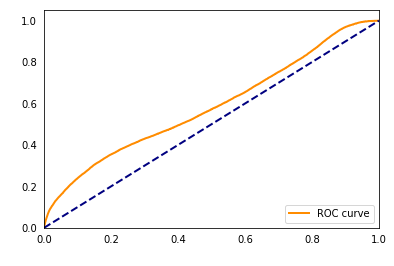

In [9]:
# Plot ROC
Y_tmp = []
gen = prediction_generator_ffd()
Y_pred = parallel_model.predict_generator(gen, steps=TEST_STEPS)
Y_pred = Y_pred[:, 0]
print(Y_pred)
Y_roc_true = np.array([[1, 0]]*SL_TEST_SIZE + [[0, 1]]*BKG_TEST_SIZE)
Y_roc_true = Y_roc_true[:, 0]
print(Y_roc_true)
# print(np.shape(Y_roc_true))
# print(np.shape(Y_pred))
fpr, tpr, _ = metrics.roc_curve(Y_roc_true, Y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.tick_params(which='both', color='white')
plt.legend(loc='lower right')
plt.show()

In [10]:
# Evaluate AUC of the ROC
metrics.roc_auc_score(Y_roc_true, Y_pred)

0.5863517294347045

In [11]:
# Free memory

X_test = []
Y_test = []


In [12]:
# Save wrong predicted patches

lst = []
wrong_lst = []
tmp = os.listdir(TEST_PATH + 'sea_lions')
for elem in tmp:
    lst.append(list((TEST_PATH + 'sea_lions/' + elem, 'sea_lion')))
tmp = rand.sample(os.listdir(TEST_PATH + 'background'), SL_TEST_SIZE)
for elem in tmp:
    lst.append(list((TEST_PATH + 'background/' + elem, 'background')))
for elem in lst:
    img = cv2.imread(elem[0])
    X = np.reshape(img_to_array(img), (1, 96, 96, 3))
    X.astype('float32')
    X /= 255
    if elem[1] == 'sea_lion':
        expected_class = [1, 0]
    else:
        expected_class = [0, 1]
    prediction = parallel_model.predict(X, batch_size=1)
    if prediction[0][0] > prediction[0][1]:
        predicted_class = [1, 0]
    else:
        predicted_class = [0, 1]
    if not(expected_class == predicted_class):
        wrong_lst.append(list((elem[0], elem[1], prediction[0][0], prediction[0][1])))

wrong_prediction_df = pd.DataFrame(data=wrong_lst, columns=["image_path", "expected_class", "sl_probability", "bkg_probability"])
wrong_prediction_df.to_csv("./wrong_predictions.csv", index=False)

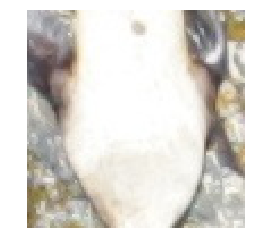

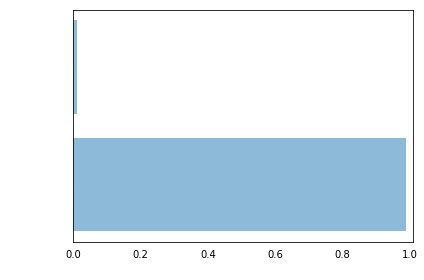

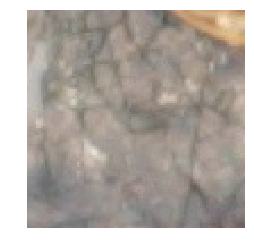

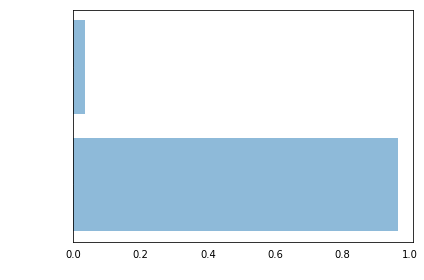

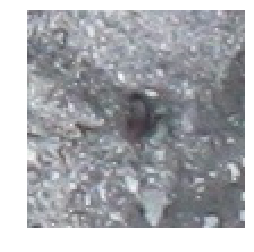

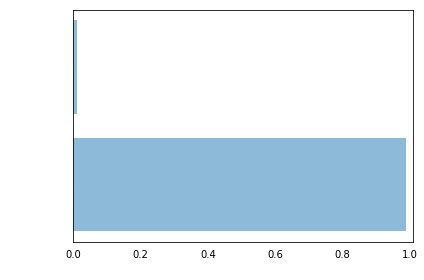

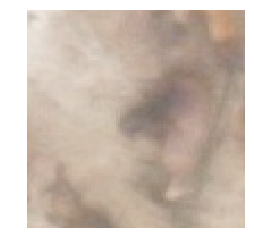

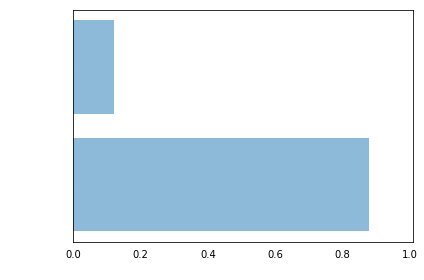

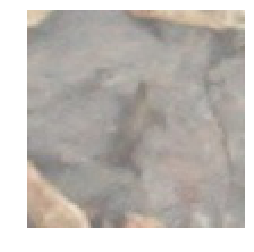

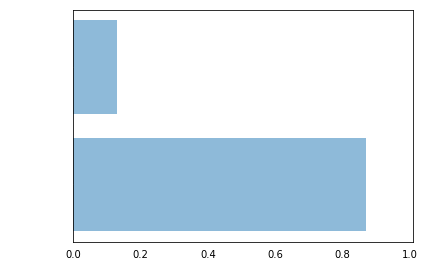

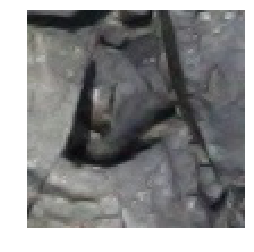

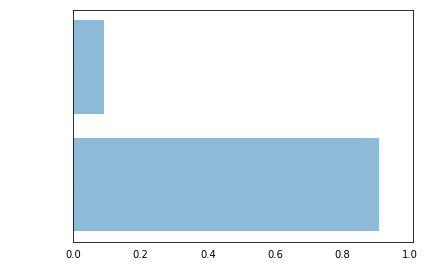

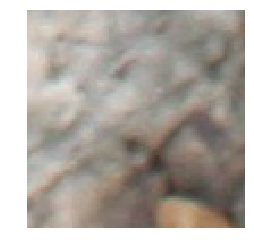

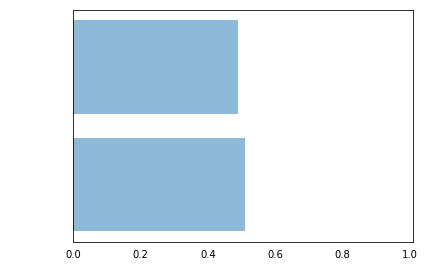

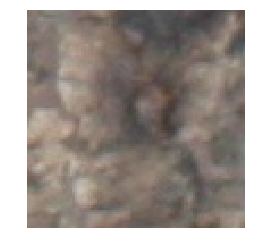

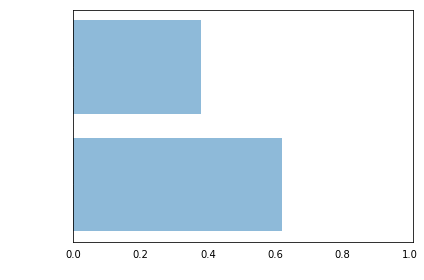

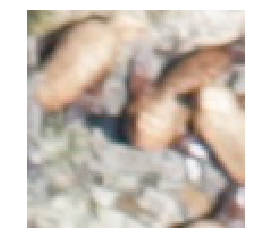

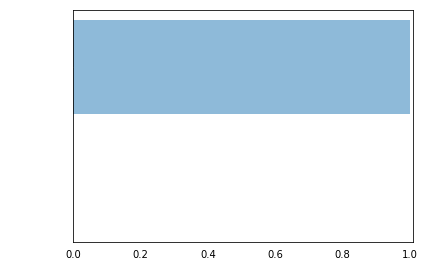

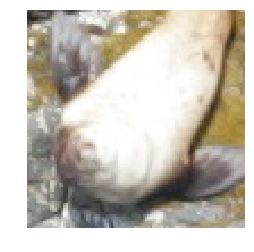

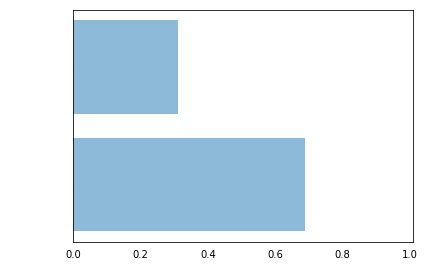

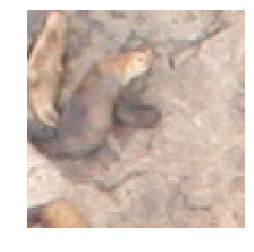

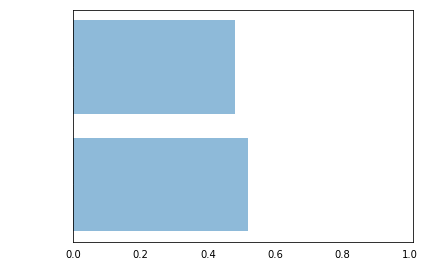

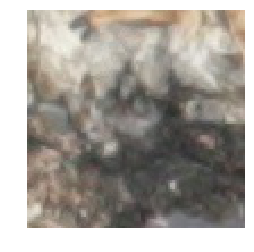

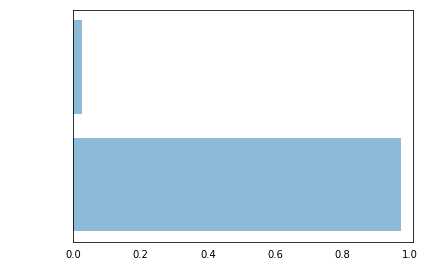

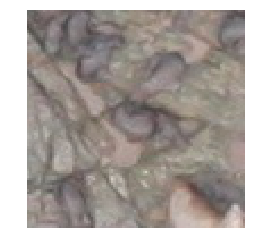

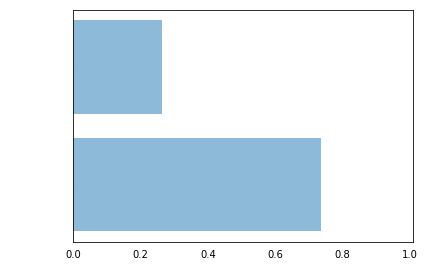

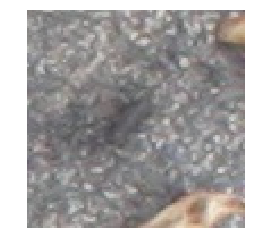

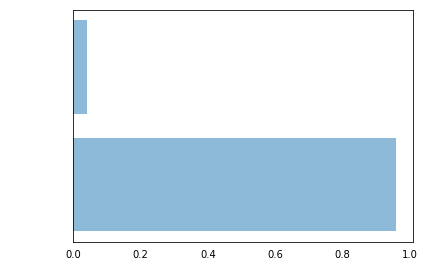

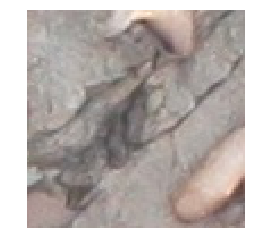

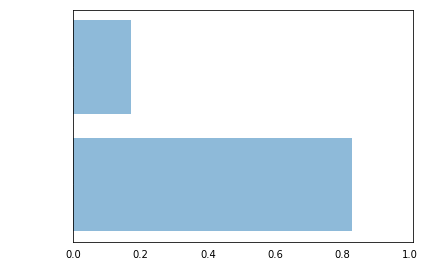

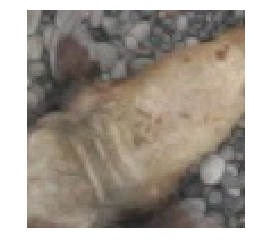

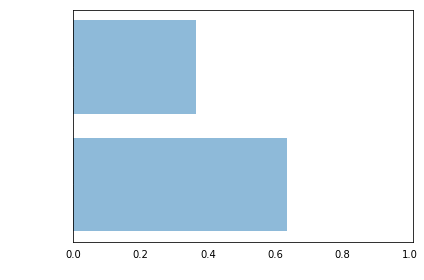

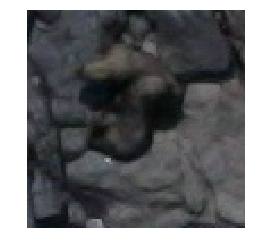

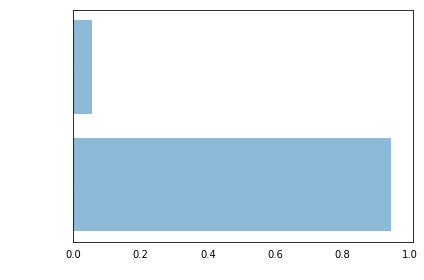

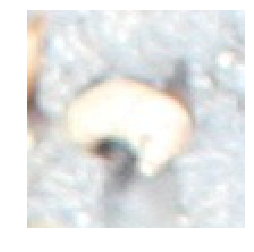

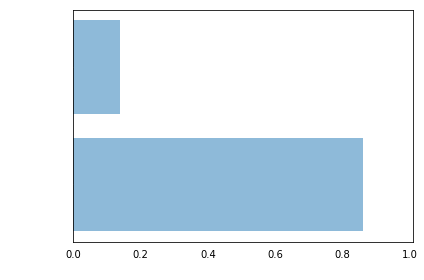

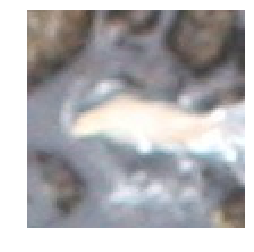

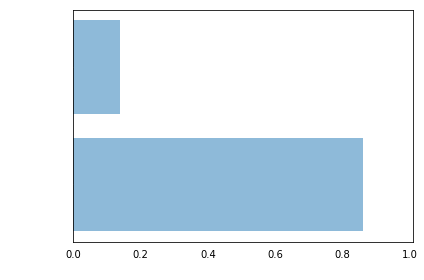

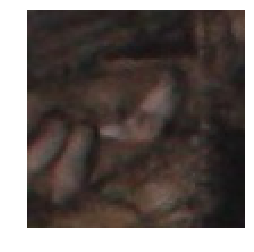

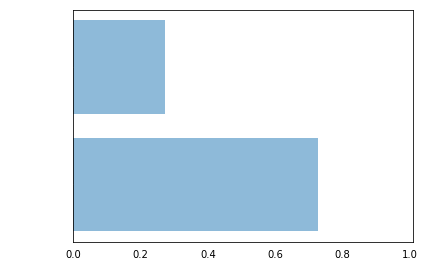

In [15]:
wrong_prediction_df = pd.read_csv("./wrong_predictions.csv")
for row in wrong_prediction_df.sample(20).iterrows():
   
    image = cv2.imread(row[1]['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    preds = [row[1]['sl_probability'], row[1]['bkg_probability']]
    plt.imshow(image)
    plt.axis('off')
    
    plt.figure()
    order = list(reversed(range(len(preds))))
    labels = ['sea lion', 'background']
    plt.barh(order, preds, alpha=0.5)
    plt.yticks(order, labels, color='white')
    plt.xlabel('Probability', color='white')
    plt.xlim(0, 1.01)
    plt.tick_params(which='both', color='white')
    plt.tight_layout()
    plt.show()